TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

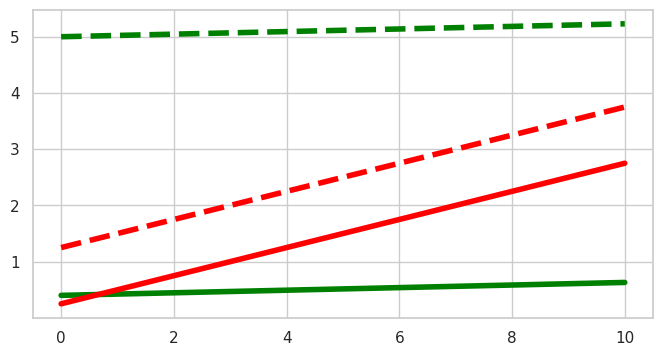

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

ax = plt.gca()

def bandwidth_function(x, size):
    # mebibytes/s
    #bw = 11464.333008
    bw = 11686.41
    # 2 - round-trip
    # x - number of workers
    # size - basic msg size
    return 2 * x * size/ (bw * 1024 * 1024) * 1000 * 1000

ops = 10**6

def aws_s3(size):
    per_gb_month = 0.023
    per_op = 0.0004 / 1000 
    return size * per_gb_month + per_op * ops

def aws_s3_write(size):
    per_gb_month = 0.023
    per_op = 0.005 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_read(size):
    per_gb_month = 0.25
    per_op = 0.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_write(size):
    per_gb_month = 0.25
    per_op = 1.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops


#xrange = range(1, 2**10 * 2**10 * 2**10, 2**10)
#xrange = range(0, 1,  1 / (2**10 * 2**10))
xrange = np.linspace(0, 10, 1024)
yrange = list(map(lambda x: aws_s3(x), xrange))
ax.plot(xrange,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)
max_read_s3 = yrange[-1]
yrange = list(map(lambda x: aws_s3_write(x), xrange))
ax.plot(xrange,yrange,color='green',linestyle='dashed', label='AWS S3', linewidth=4)

yrange = list(map(lambda x: aws_dynamodb_read(x), xrange))
ax.plot(xrange, yrange, color='red', linestyle='solid', label='AWS DynamoDB', linewidth=4)
max_read_dynamo = yrange[-1]
yrange = list(map(lambda x: aws_dynamodb_write(x), xrange))
ax.plot(xrange, yrange, color='red', linestyle='dashed', label='AWS DynamoDB', linewidth=4)

ax.set_xscale("log", basex=2)


print(f'more expensive dynamo, s3, max s3 {max_read_s3}, max dynamo {max_read_dynamo},'
      f'diff {max_read_dynamo - max_read_s3}, ratio {max_read_dynamo / max_read_s3}')


#plt = sns.lineplot(x="size", y="time", hue='type', ci='sd', estimator=p50_estimator, data=data, ax=ax)
#sns.lineplot(x="size", y="time", hue='type', ci=None, estimator=p99_estimator, data=data, ax=ax)
#ax.lines[-3].set_linestyle("dotted")
#ax.lines[-4].set_linestyle("dotted")
#ax.lines[-5].set_linestyle("dotted")
#ax.lines[-6].set_linestyle("dotted")
#ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
#locs = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 3072, 4096, 5120]])
#locs = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 5120]
#locs = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304]
#ax.xaxis.set_major_locator(ticker.NullLocator())
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter("%.1f"))
locs = [0.001, 0.01, 0.03, 0.12, 0.5, 1.0, 4.0, 10.0]
ax.xaxis.set_major_locator(ticker.FixedLocator(locs))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
#ax.set_yticks([4,5,6,10,20])
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xlabel('Storage size [GB]',fontsize=22)
ax.set_ylabel('Cost [\$]',fontsize=22)
ax.set_title('1M read (solid) and\nwrite (dotted) operations.', fontsize=22)


ax.annotate('Object storage: writes 12.5x\nmore expensive', xy=(0.01, 5), xytext=(0.01, 3.5),
            fontsize=20, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0.05)
)

ax.annotate('Key-value storage: store and\naccess 4.37x more expensive\n(2.12 $)', xy=(5.00, 1.3), xytext=(0.01, 1.5),
            fontsize=20, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0.05)
)


handles, labels = ax.get_legend_handles_labels()
handles = handles[0:3:2]
labels = labels[0:3:2]
#labels = ["RDMA, Median", "rFaaS Hot, Median", "rFaaS Warm, Median", "RDMA, P95", "rFaaS Hot, P95", "rFaaS Warm, P95", "RDMA, P99", "rFaaS Hot, P99", "rFaaS Warm, P99", "Ethernet, Mean","Ethernet, P90","Ethernet, P99"]
#labels = ["RDMA", "rFaaS Hot", "rFaaS Warm", "_RDMA, P99", "_rFaaS Hot, P99", "_rFaaS Warm, P99", "OpenWhisk", "AWS Lambda"]
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, ncol=5, bbox_to_anchor=(0.5, -0.45), loc='lower center', handletextpad=0.4, columnspacing=0.4, fontsize=20)

plt.savefig("cost_storage.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

more expensive dynamo/s3 4.023 2.75 1.2729999999999997 1.4629090909090907


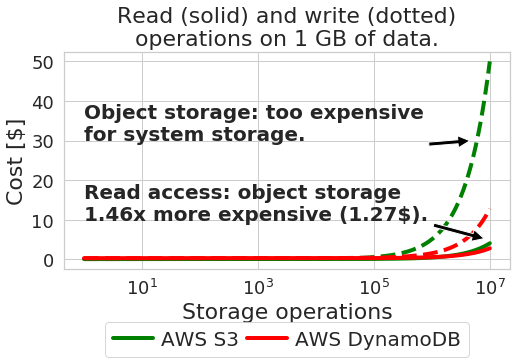

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

ax = plt.gca()

def bandwidth_function(x, size):
    # mebibytes/s
    #bw = 11464.333008
    bw = 11686.41
    # 2 - round-trip
    # x - number of workers
    # size - basic msg size
    return 2 * x * size/ (bw * 1024 * 1024) * 1000 * 1000

#ops = 10**6
size = 1

def aws_s3(ops):
    per_gb_month = 0.023
    per_op = 0.0004 / 1000 
    return size * per_gb_month + per_op * ops

def aws_s3_write(ops):
    per_gb_month = 0.023
    per_op = 0.005 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_read(ops):
    per_gb_month = 0.25
    per_op = 0.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_write(ops):
    per_gb_month = 0.25
    per_op = 1.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops


#xrange = range(1, 2**10 * 2**10 * 2**10, 2**10)
#xrange = range(0, 1,  1 / (2**10 * 2**10))
xrange = np.linspace(1, 10**7, 1024)
yrange = list(map(lambda x: aws_s3(x), xrange))
ax.plot(xrange,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)
max_read_s3 = yrange[-1]
yrange = list(map(lambda x: aws_s3_write(x), xrange))
ax.plot(xrange,yrange,color='green',linestyle='dashed', label='AWS S3', linewidth=4)

yrange = list(map(lambda x: aws_dynamodb_read(x), xrange))
ax.plot(xrange, yrange, color='red', linestyle='solid', label='AWS DynamoDB', linewidth=4)
max_read_dynamo = yrange[-1]
yrange = list(map(lambda x: aws_dynamodb_write(x), xrange))
ax.plot(xrange, yrange, color='red', linestyle='dashed', label='AWS DynamoDB', linewidth=4)

print('more expensive dynamo/s3', max_read_s3, max_read_dynamo, max_read_s3 - max_read_dynamo, max_read_s3 / max_read_dynamo)

ax.set_xscale("log", basex=10)
#ax.set_yscale("log")

#locs = [0.001, 0.01, 0.03, 0.12, 0.5, 1.0, 4.0, 10.0]
#ax.xaxis.set_major_locator(ticker.FixedLocator(locs))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
#ax.set_yticks([4,5,6,10,20])
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xlabel('Storage operations',fontsize=22)
ax.set_ylabel('Cost [\$]',fontsize=22)
ax.set_title('Read (solid) and write (dotted)\noperations on 1 GB of data.', fontsize=22)


ax.annotate('Object storage: too expensive\nfor system storage.', xy=(5*10**6, 30),
            xytext=(10**0, 30), fontsize=20, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)
ax.annotate('Read access: object storage\n1.46x more expensive (1.27$).', xy=(9*10**6, 5),
            xytext=(10**0, 10), fontsize=20, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)

handles, labels = ax.get_legend_handles_labels()
# I don't know why but matplotlib doesn't import the style for some lines
#handles[3].set_linestyle("--")
#handles[4].set_linestyle("--")
#handles[5].set_linestyle("--")

handles = handles[0:3:2]
labels = labels[0:3:2]
#labels = ["RDMA, Median", "rFaaS Hot, Median", "rFaaS Warm, Median", "RDMA, P95", "rFaaS Hot, P95", "rFaaS Warm, P95", "RDMA, P99", "rFaaS Hot, P99", "rFaaS Warm, P99", "Ethernet, Mean","Ethernet, P90","Ethernet, P99"]
#labels = ["RDMA", "rFaaS Hot", "rFaaS Warm", "_RDMA, P99", "_rFaaS Hot, P99", "_rFaaS Warm, P99", "OpenWhisk", "AWS Lambda"]
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, ncol=5, bbox_to_anchor=(0.5, -0.45), loc='lower center', handletextpad=0.4, columnspacing=0.4, fontsize=20)

plt.savefig("cost_ops.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

more expensive dynamo/s3 4.023 2.75 1.2729999999999997 1.4629090909090907
more expensive dynamo, s3, max s3 0.63, max dynamo 2.75,diff 2.12, ratio 4.365079365079365


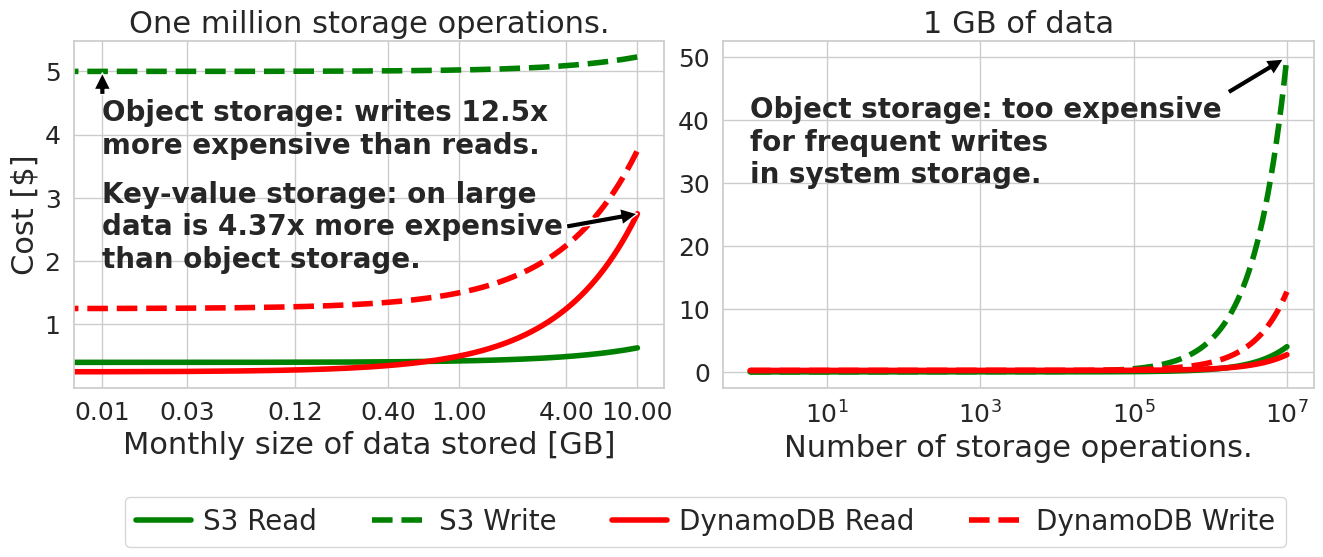

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(16,4.5)})
sns.set_style("whitegrid")

fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.1)

def aws_s3(size, ops):
    per_gb_month = 0.023
    per_op = 0.0004 / 1000 
    return size * per_gb_month + per_op * ops

def aws_s3_write(size, ops):
    per_gb_month = 0.023
    per_op = 0.005 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_read(size, ops):
    per_gb_month = 0.25
    per_op = 0.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops

def aws_dynamodb_write(size, ops):
    per_gb_month = 0.25
    per_op = 1.25 / 1000 / 1000 
    return size * per_gb_month + per_op * ops

size = 1
xrange = np.linspace(1, 10**7, 1024)
yrange = list(map(lambda x: aws_s3(size, x), xrange))
axes[1].plot(xrange,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)
max_read_s3 = yrange[-1]
yrange = list(map(lambda x: aws_s3_write(size, x), xrange))
axes[1].plot(xrange,yrange,color='green',linestyle='dashed', label='AWS S3', linewidth=4)

yrange = list(map(lambda x: aws_dynamodb_read(size, x), xrange))
axes[1].plot(xrange, yrange, color='red', linestyle='solid', label='AWS DynamoDB', linewidth=4)
max_read_dynamo = yrange[-1]
yrange = list(map(lambda x: aws_dynamodb_write(size, x), xrange))
axes[1].plot(xrange, yrange, color='red', linestyle='dashed', label='AWS DynamoDB', linewidth=4)

print('more expensive dynamo/s3', max_read_s3, max_read_dynamo, max_read_s3 - max_read_dynamo, max_read_s3 / max_read_dynamo)

axes[1].set_xscale("log", base=10)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_xlabel('Number of storage operations.',fontsize=22)
#axes[1].set_ylabel('Cost [\$]',fontsize=22)
#axes[1].set_title('Read (solid) and write (dashed)\noperations on 1 GB of data.', fontsize=22)
axes[1].set_title('1 GB of data', fontsize=22)

axes[1].annotate('Object storage: too expensive\nfor frequent writes\nin system storage.', xy=(10**7, 50),
            xytext=(10**0, 30), fontsize=20, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05)
)
#axes[1].annotate('Read access: object storage\n1.46x more expensive (1.27$).', xy=(9*10**6, 5),
#            xytext=(10**0, 10), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

ops = 10**6
xrange = np.linspace(0, 10, 1024)
yrange = list(map(lambda x: aws_s3(x,ops), xrange))
axes[0].plot(xrange,yrange,color='green',linestyle='solid', label='S3 Read', linewidth=4)
max_read_s3 = yrange[-1]
yrange = list(map(lambda x: aws_s3_write(x,ops), xrange))
axes[0].plot(xrange,yrange,color='green',linestyle='dashed', label='S3 Write', linewidth=4)

yrange = list(map(lambda x: aws_dynamodb_read(x,ops), xrange))
axes[0].plot(xrange, yrange, color='red', linestyle='solid', label='DynamoDB Read', linewidth=4)
max_read_dynamo = yrange[-1]
yrange = list(map(lambda x: aws_dynamodb_write(x,ops), xrange))
axes[0].plot(xrange, yrange, color='red', linestyle='dashed', label='DynamoDB Write', linewidth=4)

axes[0].set_xscale("log", base=2)
print(f'more expensive dynamo, s3, max s3 {max_read_s3}, max dynamo {max_read_dynamo},'
      f'diff {max_read_dynamo - max_read_s3}, ratio {max_read_dynamo / max_read_s3}')

locs = [0.001, 0.01, 0.03, 0.12, 0.4, 1.0, 4.0, 10.0]
axes[0].xaxis.set_major_locator(ticker.FixedLocator(locs))
axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_xlabel('Monthly size of data stored [GB]',fontsize=22)
axes[0].set_ylabel('Cost [\$]',fontsize=22)
#axes[0].set_title('1M read (solid) and\nwrite (dashed) operations.', fontsize=22)
axes[0].set_title('One million storage operations.', fontsize=22)

axes[0].annotate('Object storage: writes 12.5x\nmore expensive than reads.', xy=(0.01, 5), xytext=(0.01, 3.7),
            fontsize=20, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0.05)
)
axes[0].annotate(
    'Key-value storage: on large\ndata is 4.37x more expensive\nthan object storage.',
    xy=(10.00, 2.75), xytext=(0.01, 1.9),
    fontsize=20, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0)
)

handles, labels = axes[0].get_legend_handles_labels()
#handles = handles[0:3:2]
#labels = labels[0:3:2]
#axes[1].legend(handles, labels, ncol=5, bbox_to_anchor=(-0.25, -0.5), loc='lower center', handletextpad=0.4, columnspacing=0.4, fontsize=20)
axes[1].legend(handles, labels, ncol=5, bbox_to_anchor=(-0.03, -0.5), loc='lower center', handletextpad=0.4, fontsize=20)

plt.savefig("cost_microbenchmark.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)